***Importamos las librerías necesarias :***

In [23]:
import os
import torch
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from io import BytesIO
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

***Guardamos las imágenes con sus respectivas clases en "complete_df" :***

In [37]:
zip_path = './Imagenes/Trayectorias_comprimidas/longitud_28/raw-img.zip'

complete_df = pd.DataFrame()

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_list = [f for f in zip_ref.namelist() if f.startswith('raw-img/') and f.lower().endswith(('.png'))]
    complete_df['file_name'] = pd.Series(file_list)
    complete_df['class_name'] = complete_df['file_name'].map(lambda x: x.split('/')[-2])

#### COMPROBACIÓN ####
print("Número total de imágenes:", len(complete_df))
class_counts = complete_df['class_name'].value_counts()
print(class_counts)

Número total de imágenes: 9670
class_name
Fishing      1959
Container    1951
Tanker       1935
Cargo        1923
Cruise       1902
Name: count, dtype: int64


***Dividimos "complete_df" en entrenamiento y test :***

In [38]:
complete_df = complete_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 0.2
train_df_list = []
test_df_list = []

classes = complete_df['class_name'].unique()

for class_name in classes:
    class_subset = complete_df[complete_df['class_name'] == class_name]
    
    test_count = int(len(class_subset) * test_size)
    
    test_df_list.append(class_subset.iloc[:test_count])
    train_df_list.append(class_subset.iloc[test_count:])

train_df = pd.concat(train_df_list).reset_index(drop=True)
test_df = pd.concat(test_df_list).reset_index(drop=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### COMPROBACIÓN ####
print(f"Nº de imágenes en train: {len(train_df)}")
print(train_df['class_name'].value_counts())
print()
print(f"Nº de imágenes en test: {len(test_df)}")
print(test_df['class_name'].value_counts())
print()
print("Ejm. conjunto train:")
print(train_df.head(10))
print()
print("Ejm. conjunto test:")
print(test_df.head(10))

Nº de imágenes en train: 7738
class_name
Fishing      1568
Container    1561
Tanker       1548
Cargo        1539
Cruise       1522
Name: count, dtype: int64

Nº de imágenes en test: 1932
class_name
Fishing      391
Container    390
Tanker       387
Cargo        384
Cruise       380
Name: count, dtype: int64

Ejm. conjunto train:
                                           file_name class_name
0     raw-img/Cargo/Trayectoria_comprimida_14039.png      Cargo
1    raw-img/Cruise/Trayectoria_comprimida_15027.png     Cruise
2   raw-img/Fishing/Trayectoria_comprimida_13197.png    Fishing
3    raw-img/Fishing/Trayectoria_comprimida_6106.png    Fishing
4  raw-img/Container/Trayectoria_comprimida_7576.png  Container
5    raw-img/Cruise/Trayectoria_comprimida_15250.png     Cruise
6      raw-img/Cargo/Trayectoria_comprimida_9236.png      Cargo
7       raw-img/Cruise/Trayectoria_comprimida_37.png     Cruise
8     raw-img/Tanker/Trayectoria_comprimida_4613.png     Tanker
9     raw-img/Tanker/Trayecto

***Imágenes de entrenamiento y test antes del pre-procesado :***

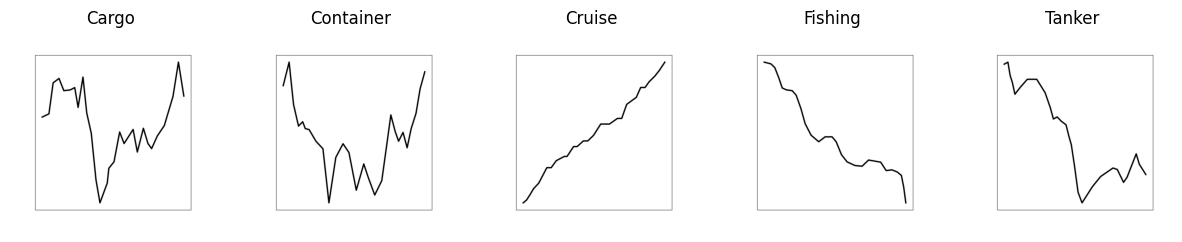

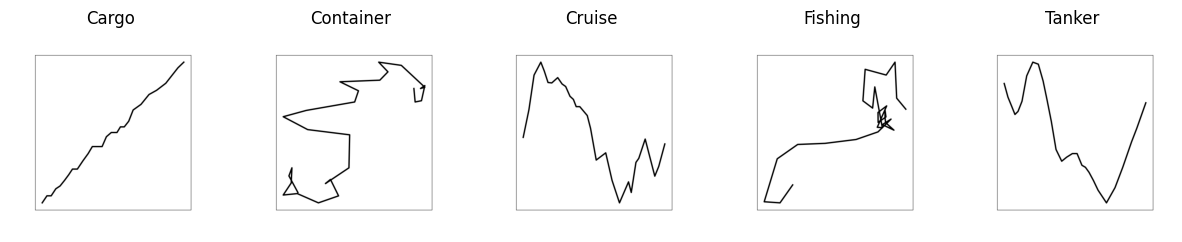

In [39]:
def mostrar_imagenes_antes_preprocesado(df):
    plt.figure(figsize=(15, 15))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        grouped = df.groupby('class_name')
        for i, (class_name, group) in enumerate(grouped):
            image_path = group['file_name'].iloc[0]
            with zip_ref.open(image_path) as image_file:
                image = Image.open(image_file).convert("RGB")
            plt.subplot(1, len(grouped), i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.show()

mostrar_imagenes_antes_preprocesado(train_df)
mostrar_imagenes_antes_preprocesado(test_df)


***Pre-procesado de las imágenes :***

In [40]:
IMG_SIZE = (227, 227)
X_train = []
y_train = []
X_test = []
y_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} disponible")

transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])

def preprocesado_imagen(zip_ref, image_path):
    with zip_ref.open(image_path) as image_file:
        image = Image.open(image_file).convert("RGB")
        image = transform(image)
        return image

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for index, row in train_df.iterrows():
        image_tensor = preprocesado_imagen(zip_ref, row['file_name'])
        X_train.append(image_tensor)
        y_train.append(row['class_name'])

    for index, row in test_df.iterrows():
        image_tensor = preprocesado_imagen(zip_ref, row['file_name'])
        X_test.append(image_tensor)
        y_test.append(row['class_name'])

X_train = torch.stack(X_train)
X_test = torch.stack(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train = torch.tensor(encoder.fit_transform(y_train_encoded.reshape(-1, 1)), dtype=torch.float32)
y_test = torch.tensor(encoder.transform(y_test_encoded.reshape(-1, 1)), dtype=torch.float32)

#### COMPROBACIÓN ####
print("X_train_tensor:", X_train.shape, X_train.device)
print("y_train_tensor:", y_train.shape, y_train.device)
print("X_test_tensor:", X_test.shape, X_test.device)
print("y_test_tensor:", y_test.shape, y_test.device)

cuda disponible
X_train_tensor: torch.Size([7738, 3, 227, 227]) cpu
y_train_tensor: torch.Size([7738, 5]) cpu
X_test_tensor: torch.Size([1932, 3, 227, 227]) cpu
y_test_tensor: torch.Size([1932, 5]) cpu


***AlexNet :***

In [41]:
class AlexNet(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(AlexNet, self).__init__()

        #Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        #Capas fully connected
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

***Entrenamiento del modelo AlexNet :***

In [42]:
input_shape = (3, 227, 227)
num_classes = 5
batch_size = 32
num_epochs = 25

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelo = AlexNet(input_shape, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001)

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(num_epochs):
    modelo.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = modelo(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, predicted = torch.max(output, 1)
        _, actual = torch.max(labels, 1)
        total_train += labels.size(0)
        correct_train += (predicted == actual).sum().item()

        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    modelo.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            total += labels.size(0)
            correct += (predicted == actual).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} ✅ | Train Acc: {train_acc:.2f}% - Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}% - Val Loss: {avg_val_loss:.4f}")

Epoch 1/25: 100%|██████████| 194/194 [00:17<00:00, 11.02it/s, loss=1.64]


Epoch 1/25 ✅ | Train Acc: 19.98% - Train Loss: 1.6348 | Val Acc: 18.99% - Val Loss: 1.6114


Epoch 2/25: 100%|██████████| 194/194 [00:15<00:00, 12.92it/s, loss=1.62]


Epoch 2/25 ✅ | Train Acc: 19.84% - Train Loss: 1.6103 | Val Acc: 19.90% - Val Loss: 1.6106


Epoch 3/25: 100%|██████████| 194/194 [00:15<00:00, 12.75it/s, loss=1.62]


Epoch 3/25 ✅ | Train Acc: 19.29% - Train Loss: 1.6104 | Val Acc: 18.99% - Val Loss: 1.6096


Epoch 4/25: 100%|██████████| 194/194 [00:15<00:00, 12.57it/s, loss=1.61]


Epoch 4/25 ✅ | Train Acc: 20.50% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6099


Epoch 5/25: 100%|██████████| 194/194 [00:15<00:00, 12.59it/s, loss=1.63]


Epoch 5/25 ✅ | Train Acc: 20.23% - Train Loss: 1.6098 | Val Acc: 18.99% - Val Loss: 1.6099


Epoch 6/25: 100%|██████████| 194/194 [00:15<00:00, 12.51it/s, loss=1.62]


Epoch 6/25 ✅ | Train Acc: 20.15% - Train Loss: 1.6098 | Val Acc: 18.99% - Val Loss: 1.6101


Epoch 7/25: 100%|██████████| 194/194 [00:15<00:00, 12.33it/s, loss=1.63]


Epoch 7/25 ✅ | Train Acc: 19.16% - Train Loss: 1.6099 | Val Acc: 18.99% - Val Loss: 1.6104


Epoch 8/25: 100%|██████████| 194/194 [00:15<00:00, 12.62it/s, loss=1.61]


Epoch 8/25 ✅ | Train Acc: 20.47% - Train Loss: 1.6096 | Val Acc: 19.90% - Val Loss: 1.6105


Epoch 9/25: 100%|██████████| 194/194 [00:14<00:00, 12.96it/s, loss=1.63]


Epoch 9/25 ✅ | Train Acc: 20.29% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6105


Epoch 10/25: 100%|██████████| 194/194 [00:15<00:00, 12.74it/s, loss=1.61]


Epoch 10/25 ✅ | Train Acc: 19.69% - Train Loss: 1.6097 | Val Acc: 19.90% - Val Loss: 1.6103


Epoch 11/25: 100%|██████████| 194/194 [00:15<00:00, 12.42it/s, loss=1.63]


Epoch 11/25 ✅ | Train Acc: 19.82% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6103


Epoch 12/25: 100%|██████████| 194/194 [00:15<00:00, 12.33it/s, loss=1.63]


Epoch 12/25 ✅ | Train Acc: 20.15% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6109


Epoch 13/25: 100%|██████████| 194/194 [00:15<00:00, 12.49it/s, loss=1.63]


Epoch 13/25 ✅ | Train Acc: 19.85% - Train Loss: 1.6098 | Val Acc: 18.99% - Val Loss: 1.6106


Epoch 14/25: 100%|██████████| 194/194 [00:15<00:00, 12.46it/s, loss=1.63]


Epoch 14/25 ✅ | Train Acc: 20.63% - Train Loss: 1.6094 | Val Acc: 18.99% - Val Loss: 1.6106


Epoch 15/25: 100%|██████████| 194/194 [00:15<00:00, 12.77it/s, loss=1.63]


Epoch 15/25 ✅ | Train Acc: 19.84% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6103


Epoch 16/25: 100%|██████████| 194/194 [00:14<00:00, 13.11it/s, loss=1.61]


Epoch 16/25 ✅ | Train Acc: 19.79% - Train Loss: 1.6097 | Val Acc: 18.99% - Val Loss: 1.6106


Epoch 17/25: 100%|██████████| 194/194 [00:15<00:00, 12.93it/s, loss=1.63]


Epoch 17/25 ✅ | Train Acc: 19.40% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6104


Epoch 18/25: 100%|██████████| 194/194 [00:14<00:00, 13.08it/s, loss=1.63]


Epoch 18/25 ✅ | Train Acc: 19.50% - Train Loss: 1.6094 | Val Acc: 18.99% - Val Loss: 1.6104


Epoch 19/25: 100%|██████████| 194/194 [00:14<00:00, 12.94it/s, loss=1.63]


Epoch 19/25 ✅ | Train Acc: 19.95% - Train Loss: 1.6095 | Val Acc: 18.99% - Val Loss: 1.6105


Epoch 20/25: 100%|██████████| 194/194 [00:15<00:00, 12.89it/s, loss=1.63]


Epoch 20/25 ✅ | Train Acc: 20.24% - Train Loss: 1.6094 | Val Acc: 19.90% - Val Loss: 1.6104


Epoch 21/25: 100%|██████████| 194/194 [00:15<00:00, 12.83it/s, loss=1.63]


Epoch 21/25 ✅ | Train Acc: 20.34% - Train Loss: 1.6093 | Val Acc: 18.99% - Val Loss: 1.6106


Epoch 22/25: 100%|██████████| 194/194 [00:15<00:00, 12.68it/s, loss=1.63]


Epoch 22/25 ✅ | Train Acc: 20.52% - Train Loss: 1.6095 | Val Acc: 18.99% - Val Loss: 1.6105


Epoch 23/25: 100%|██████████| 194/194 [00:14<00:00, 12.98it/s, loss=1.62]


Epoch 23/25 ✅ | Train Acc: 19.52% - Train Loss: 1.6095 | Val Acc: 18.99% - Val Loss: 1.6104


Epoch 24/25: 100%|██████████| 194/194 [00:15<00:00, 12.79it/s, loss=1.61]


Epoch 24/25 ✅ | Train Acc: 20.73% - Train Loss: 1.6094 | Val Acc: 18.99% - Val Loss: 1.6101


Epoch 25/25: 100%|██████████| 194/194 [00:15<00:00, 12.81it/s, loss=1.63]


Epoch 25/25 ✅ | Train Acc: 20.15% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6106


***AlexNet_8 :***

Epoch 25/25 ✅ | Train Acc: 20.07% - Train Loss: 1.6096 | Val Acc: 19.49% - Val Loss: 1.6098

***AlexNet_18 :***

Epoch 25/25 ✅ | Train Acc: 19.66% - Train Loss: 1.6097 | Val Acc: 20.09% - Val Loss: 1.6094

***AlexNet_28 :***

Epoch 25/25 ✅ | Train Acc: 20.15% - Train Loss: 1.6096 | Val Acc: 18.99% - Val Loss: 1.6106

***Graficar los resultados del entrenamiento :***

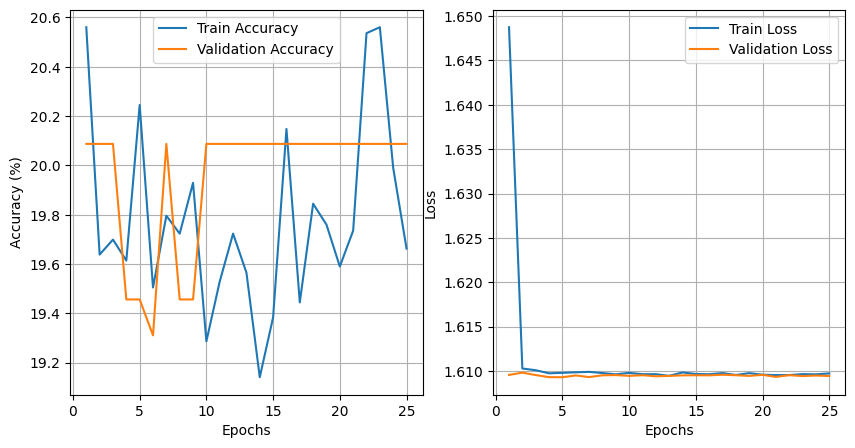

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

output_dir = './Resultados_entrenamiento/Representacion_2/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f'{output_dir}AlexNet_28.png')
plt.show()